In [1]:
# Please execute/shift-return this cell everytime you run the notebook.  Don't edit it. 
%load_ext autoreload
%autoreload 2
from notebook import * 

# Amdahl's Law

## The starting example -- sorting

In [2]:
render_code("./gpusort/main.cu", show="main")

// ./gpusort/main.cu:516-682 (167 lines)
int main( int argc, char** argv)
{ 

  // Create timers for each sort
    struct timeval time_start, time_end, program_start, program_end;
    double input_time=0;
    gettimeofday(&program_start, NULL);	

    sdkCreateTimer(&uploadTimer);
    sdkCreateTimer(&downloadTimer);
    sdkCreateTimer(&bucketTimer);
    sdkCreateTimer(&mergeTimer);
    sdkCreateTimer(&totalTimer);
    sdkCreateTimer(&cpuTimer);
	int numElements = 0;
	int method=0;
    // Number of elements in the test bed
    	gettimeofday(&time_start, NULL);
#ifdef READING_FROM_BINARY
        numElements = atoi(argv[2]);
	if (argc == 4)
		method = atoi(argv[3]);
#else
       	if(strcmp(argv[1],"r") ==0) {
	         numElements = SIZE; 
	    }
	else {
		FILE *fp;
	    fp = fopen(argv[1],"r");
	    if(fp == NULL) {
	        cout << "Error reading file" << endl;
	        exit(EXIT_FAILURE);
	    }
	    int count = 0;
	    float c;

	    while(fscanf(fp,"%f",&c) != EOF) {
	        count++;
        }
	    fclose(fp);
	    numElements = count;
    }
#endif

	cout << "Sorting list of " << numElements << " floats\n";
	// Generate random data
	// Memory space the list of random floats will take up
	int mem_size = numElements * sizeof(float); 
	// Allocate enough for the input list
	float *cpu_idata = (float *)malloc(mem_size);
	// Allocate enough for the output list on the cpu side
	float *cpu_odata = (float *)malloc(mem_size);
	// Allocate enough memory for the output list on the gpu side
	float *gpu_odata = (float *)malloc(mem_size);

	float datamin = FLT_MAX; 
	float datamax = -FLT_MAX; 
	if(strcmp(argv[1],"r")==0) {

	for (int i = 0; i < numElements; i++) {
	// Generate random floats between 0 and 1 for the input data
		cpu_idata[i] = ((float) rand() / RAND_MAX); 
	//Compare data at index to data minimum, if less than current minimum, set that element as new minimum
		datamin = min(cpu_idata[i], datamin);
	//Same as above but for maximum
		datamax = max(cpu_idata[i], datamax);
	}
    }	else {
	FILE *fp;
#ifdef READING_FROM_BINARY
	fp = fopen(argv[1],"rb");
	fread(cpu_idata,sizeof(float),numElements,fp);
	fclose(fp);
   	gettimeofday(&time_end, NULL);
    input_time = ((time_end.tv_sec * 1000000 + time_end.tv_usec) - (time_start.tv_sec * 1000000 + time_start.tv_usec))/1000000.0;
	printf("FileInput %lf seconds\n",input_time);
	
    /*	for(int i = 0; i < numElements; i++) {
	datamin = min(cpu_idata[i],datamin);
	datamax = max(cpu_idata[i],datamax);
	}*/

	datamin = 0.0;
	datamax = 16777215.0;
#else
	fp = fopen(argv[1],"r");
	for(int i = 0; i < numElements; i++) {
	fscanf(fp,"%f",&cpu_idata[i]);
	datamin = min(cpu_idata[i],datamin);
	datamax = max(cpu_idata[i],datamax);
	}
	fclose(fp);
   	gettimeofday(&time_end, NULL);
    input_time = ((time_end.tv_sec * 1000000 + time_end.tv_usec) - (time_start.tv_sec * 1000000 + time_start.tv_usec))/1000000.0;
	printf("FileInput %lf seconds\n",input_time);
    	gettimeofday(&time_start, NULL);	
#endif
	}
#ifndef CPU
	cout << "Sorting on GPU..." << flush; 
	// GPU Sort
	if(method == 0)
	for (int i = 0; i < TEST; i++) 
        MergeSort(cpu_idata, numElements, THREADS_PER_BLOCK, numElements/THREADS_PER_BLOCK);
//		gpu_quicksort(cpu_idata, gpu_odata, numElements);		
	else {
	// Using bitonic sort
	for (int i = 0; i < TEST; i++) 
		bitonic_sort(cpu_idata, gpu_odata, numElements);		
	}
#endif

#if defined(VERIFY) || (defined CPU)
	cout << "Sorting on CPU..." << flush; 
	// Start_CPU_Sort
	sdkStartTimer(&cpuTimer); 
	memcpy(cpu_odata, cpu_idata, mem_size);
    qsort(cpu_odata, numElements, sizeof(float), compare);
	sdkStopTimer(&cpuTimer); 
    // End_CPU_Sort 
	cout << "done.\n";
	#ifdef VERIFY
    cout << "Checking result..." << flush; 
	// Result checking
	int count = 0; 
	for(int i = 0; i < numElements; i++)
		if(fabs(cpu_odata[i] - gpu_odata[i])> 0.0002)
		{
			printf("Sort missmatch on element %d: \n", i); 
			printf("CPU = %f : GPU = %f\n", cpu_odata[i], gpu_odata[i]); 
			count++; 
			break; 
		}

## Where is the most time critical part of my program?

In [20]:
! cd gpusort; make clean; make
! echo "File on H.D.D.; Sorting on CPU"
! cd ./gpusort; echo "config,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host" > sort.csv; echo -n "HDD+CPU," >> sort.csv; source ./run_CPU 2>> sort.csv

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
File on H.D.D.; Sorting on CPU
Sorting list of 134217728 floats
FileInput 1.844024 seconds
Sorting on CPU...done.
Total CPU execution time: 14.610000 seconds


In [21]:
display_df_mono(render_csv("./gpusort/sort.csv", columns=["ET","FileInput","CPU_Kernel"]))

,index,ET,FileInput,CPU_Kernel
0,0,16.454072,1.844024,14.610000


In [5]:
! lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   24
  On-line CPU(s) list:    0-23
Vendor ID:                GenuineIntel
  Model name:             13th Gen Intel(R) Core(TM) i7-13700
    CPU family:           6
    Model:                183
    Thread(s) per core:   2
    Core(s) per socket:   16
    Socket(s):            1
    Stepping:             1
    CPU(s) scaling MHz:   52%
    CPU max MHz:          5200.0000
    CPU min MHz:          800.0000
    BogoMIPS:             4224.00
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 s
                          s ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc 
                          art arch_perfmon pebs bts rep_good nopl xtopology nons
                          top_tsc c

### Use gprof to figure out the timing breakdown

In [18]:
! cd gpusort; make clean; make EXTRA_FLAGS=-pg 
! cd ./gpusort; source ./run_CPU

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -pg  -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -pg  -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
Sorting list of 134217728 floats
FileInput 3.291037 seconds
Sorting on CPU...done.
Total CPU execution time: 26.048994 seconds
29.340075, 3.291037, 26.048994, 0.000000, 0.000000, 0.000000


In [19]:
! cd gpusort; gprof ./hybridsort_cpu ./gmon.out

Flat profile:

Each sample counts as 0.01 seconds.
  %   cumulative   self              self     total           
 time   seconds   seconds    calls  Ts/call  Ts/call  name    
100.00      1.88     1.88                             compare(void const*, void const*)
  0.00      1.88     0.00        6     0.00     0.00  __cudaUnregisterBinaryUtil()
  0.00      1.88     0.00        6     0.00     0.00  StopWatchLinux::~StopWatchLinux()
  0.00      1.88     0.00        5     0.00     0.00  StopWatchLinux::getTime()
  0.00      1.88     0.00        1     0.00     0.00  StopWatchLinux::stop()
  0.00      1.88     0.00        1     0.00     0.00  StopWatchLinux::start()

 %         the percentage of the total running time of the
time       program used by this function.

cumulative a running sum of the number of seconds accounted
 seconds   for by this function and those listed above it.

 self      the number of seconds accounted for by this
seconds    function alone.  This is the major sort 

## Amdahl's Law -- optimizating is a moving target

In [8]:
render_code("./gpusort/main.cu", lang="c++", show="bitonic_sort")

// ./gpusort/main.cu:63-92 (30 lines)
void bitonic_sort(float *values, float *out_values, int num_of_elements)
{
  float *dev_values;
  size_t size = num_of_elements * sizeof(float);
  int BLOCKS = num_of_elements/THREADS_PER_BLOCK; 

  cudaMalloc((void**) &dev_values, size);
  sdkStartTimer(&uploadTimer);
  cudaMemcpy(dev_values, values, size, cudaMemcpyHostToDevice);
  sdkStopTimer(&uploadTimer); 
  dim3 blocks(BLOCKS,1);    /* Number of blocks   */
  dim3 threads(THREADS_PER_BLOCK,1);  /* Number of threads  */

  sdkStartTimer(&totalTimer); 
  int j, k;
  /* Major step */
  for (k = 2; k <= num_of_elements; k <<= 1) {
    /* Minor step */
    for (j=k>>1; j>0; j=j>>1) {
      bitonic_sort_step<<<blocks, threads>>>(dev_values, j, k);
    }
  }
		cudaThreadSynchronize(); 
  sdkStopTimer(&totalTimer); 
  sdkStartTimer(&downloadTimer);
  cudaMemcpy((void *)out_values, (void *)dev_values,  num_of_elements*sizeof(float), cudaMemcpyDeviceToHost);
//		checkCudaErrors(cudaMemcpy((void *)out_values, (void *)dev_values, num_of_elements*sizeof(float), cudaMemcpyDeviceToHost));
  sdkStopTimer(&downloadTimer); 
  cudaFree(dev_values);
}

In [9]:
! nvidia-smi -a


==============NVSMI LOG==============

Timestamp                                 : Tue Oct  8 08:47:48 2024
Driver Version                            : 555.42.06
CUDA Version                              : 12.5

Attached GPUs                             : 1
GPU 00000000:01:00.0
    Product Name                          : NVIDIA GeForce RTX 4070 Ti SUPER
    Product Brand                         : GeForce
    Product Architecture                  : Ada Lovelace
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Disabled
    Addressing Mode                       : None
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
  

In [22]:
! cd gpusort; make clean; make
# ! ssh htseng@azelf "source ./courses/CS203/demo/amdahlslaw/gpusort/run_CPU"
! echo "File on H.D.D.; Sorting on GPU"
! cd gpusort; echo -n "HDD+GPU," >> sort.csv; source ./run 2>> sort.csv

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
File on H.D.D.; Sorting on GPU
Sorting list of 134217728 floats
FileInput 1.842134 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.547332 seconds
    - Upload		: 0.042724 seconds
    - Download		: 0.150249 seconds


In [24]:
display_df_mono(render_csv("./gpusort/sort.csv"))

,index,config,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host
0,0,HDD+CPU,16.454072,1.844024,14.610000,0.000000,0.000000,0.000000
1,1,HDD+GPU,2.738635,1.842134,0.000000,0.547332,0.042724,0.150249


In [12]:
! echo "File on S.S.D.; Sorting on GPU"
! cd gpusort; echo -n "SSD+GPU," >> sort.csv; source ./run_SSD 2>> sort.csv

File on S.S.D.; Sorting on GPU
Sorting list of 134217728 floats
FileInput 0.355717 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.546618 seconds
    - Upload		: 0.043731 seconds
    - Download		: 0.152337 seconds


In [13]:
display_df_mono(render_csv("./gpusort/sort.csv"))

,index,config,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host
0,0,HDD+CPU,16.442648,1.848451,14.594132,0.000000,0.000000,0.000000
1,1,HDD+GPU,2.745959,1.842435,0.000000,0.547476,0.043394,0.150886
2,2,SSD+GPU,1.250799,0.355717,0.000000,0.546618,0.043731,0.152337


## Amdahl's Law on parallel programming

In [17]:
compare([do_render_code("vmul/vmul_cuda.cu"),do_render_code("vmul/vmul_cpu.c")])

In [27]:
! cd vmul; make clean; make
! echo "Hardware,THREADS,CPUTIME,HOST2GPU,GPUTIME,GPU2HOST" > ./vmul/vmul.csv
! echo "CPU based vul"; echo -n "CPU," >> ./vmul/vmul.csv
! time ./vmul/vmul 33554432 1 0 30 2>> ./vmul/vmul.csv
! echo "GPU based vul"
### i stands for "How many iterations each thread performs 
### -- the larger the number, the fewer the parallelism
! for i in 1 2 4 8 16 32 64 128 256 512 1024 2048 4096 8192; do echo -n "GPU," >> ./vmul/vmul.csv; time ./vmul/vmul 33554432 $i 1 30 2>> ./vmul/vmul.csv ; done

rm -f vmul *.o
gcc -O3 vmul.c -c
gcc -O3 vmul_cpu.c -c
/usr/local/cuda/bin/nvcc -O3 -w vmul_cuda.cu -c
gcc -O3 *.o -lcuda -lcudart -L/usr/local/cuda/lib64 -o vmul
CPU based vul
Using CPU
kernel: 0.303034 seconds

real	0m1.095s
user	0m0.988s
sys	0m0.102s
GPU based vul
memcpy (to device): 0.185460 seconds
Using GPU
kernel: 0.007485 seconds
memcpy (to host): 0.020493 seconds

real	0m1.063s
user	0m0.750s
sys	0m0.302s
memcpy (to device): 0.153004 seconds
Using GPU
kernel: 0.013181 seconds
memcpy (to host): 0.020240 seconds

real	0m1.026s
user	0m0.746s
sys	0m0.274s
memcpy (to device): 0.152418 seconds
Using GPU
kernel: 0.025123 seconds
memcpy (to host): 0.020501 seconds

real	0m1.039s
user	0m0.764s
sys	0m0.270s
memcpy (to device): 0.155909 seconds
Using GPU
kernel: 0.032013 seconds
memcpy (to host): 0.020960 seconds

real	0m1.039s
user	0m0.744s
sys	0m0.290s
memcpy (to device): 0.148291 seconds
Using GPU
kernel: 0.050094 seconds
memcpy (to host): 0.020478 seconds

real	0m1.048s
user	0m0.783s


,index,Hardware,THREADS,CPUTIME,HOST2GPU,GPUTIME,GPU2HOST,TOTAL
0,0,CPU,0.000000,0.303034,0.000000,0.000000,0.000000,0.303034
14,14,GPU,4.000000,0.000000,0.153382,0.284860,0.020723,0.458965
13,13,GPU,8.000000,0.000000,0.153003,0.144057,0.020675,0.317735
12,12,GPU,16.000000,0.000000,0.147521,0.071892,0.020421,0.239834
11,11,GPU,32.000000,0.000000,0.152814,0.054987,0.020616,0.228417
10,10,GPU,64.000000,0.000000,0.154512,0.057552,0.020337,0.232401
9,9,GPU,128.000000,0.000000,0.149358,0.053427,0.020317,0.223102
8,8,GPU,256.000000,0.000000,0.149127,0.053112,0.020239,0.222478
7,7,GPU,512.000000,0.000000,0.148794,0.051576,0.020357,0.220727
6,6,GPU,1024.000000,0.000000,0.149019,0.050483,0.020375,0.219877


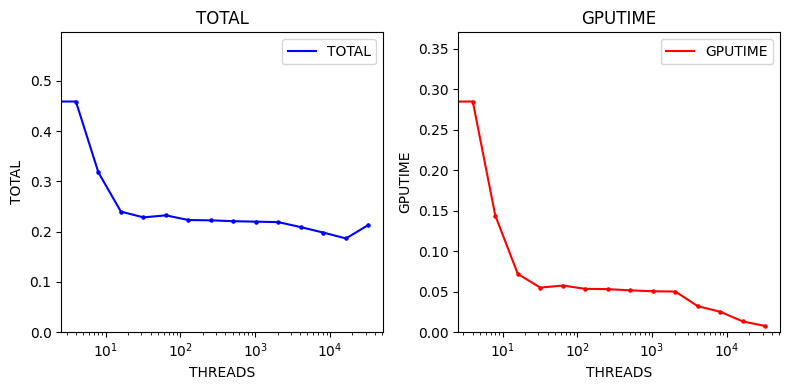

In [28]:
df = render_csv("./vmul/vmul.csv")
df["TOTAL"] = df["CPUTIME"] + df["HOST2GPU"] + df["GPUTIME"] + df["GPU2HOST"]
df = df.sort_values(by=["THREADS"], ascending=True)
display_df_mono(df)
plotPE(df=df, logx=2, lines=True, what=[ ('THREADS', "TOTAL"), ('THREADS', "GPUTIME")], columns=2)